# Application: Learning optimal restrictions in a continuous-action game

This notebook corresponds to Section 5.3 of the paper "Grams & Oesterle (forthcoming). _DRAMA at the PettingZoo: Dynamically Restricted Action Spaces for Multi-Agent Reinforcement Learning Frameworks_."

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append(f'{os.getcwd()}/../../')

In [3]:
import numpy as np

from gymnasium.spaces import Discrete, Box, Space

from src.restrictions import DiscreteVectorRestriction
from src.wrapper import RestrictionWrapper
from src.restrictors import Restrictor, RestrictorActionSpace, DiscreteVectorActionSpace

from examples.utils import play
from examples.traffic.env import TrafficEnvironment
from examples.traffic.agent import TrafficAgent
from examples.traffic.restrictor import TrafficRestrictor

from examples.traffic.utils import create_graph, analyze_graph, edge_path_to_node_path

## Test: Without Governance

In [4]:
graph = create_graph([
    ((0, 1), (0, 8, 1)), 
    ((0, 2), (11, 0, 0)), 
    ((1, 2), (1, 0, 0)), 
    ((1, 3), (11, 0, 0)), 
    ((2, 3), (0, 8, 1))
])

In [5]:
possible_routes = [(0, 3)]

In [6]:
number_of_agents = 2

edge_list, edge_indices, edge_latencies, routes, route_list, route_indices = analyze_graph(graph)

agents = {f'agent_{i}': TrafficAgent(routes, route_indices, edge_indices) for i in range (number_of_agents)}
env = TrafficEnvironment(graph, list(agents), possible_routes, number_of_steps=100)
policies = {id: agent.act for id, agent in agents.items()}

trajectory = play(env, policies, max_iter=50, verbose=False, record_trajectory=True, render_mode=None)

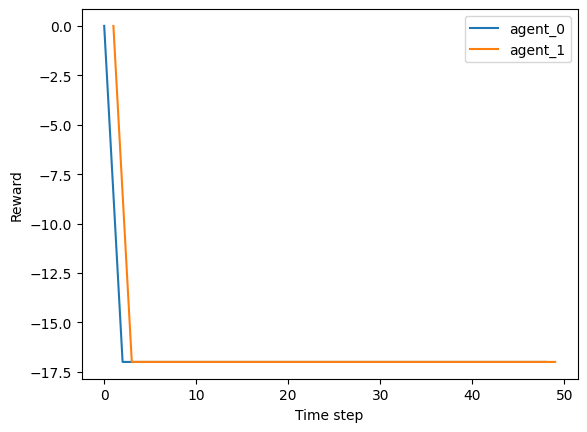

In [7]:
trajectory.groupby('agent')['reward'].plot(legend=True, xlabel='Time step', ylabel='Reward');

Text(0.5, 0, 'Time step')

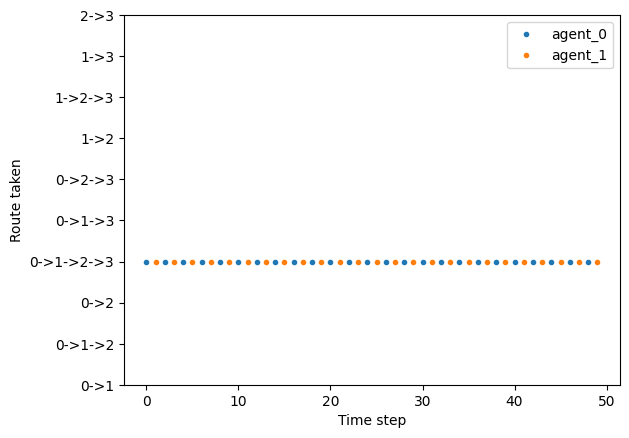

In [8]:
ax, *_ = trajectory.groupby('agent')['action'].plot(style='.', legend=True)
ax.set_yticks(list(route_indices.values()), [edge_path_to_node_path(route, edge_list) for route in route_indices.keys()]);
ax.set_ylabel('Route taken')
ax.set_xlabel('Time step')

## With governance

In [92]:
class TrafficRestrictor(Restrictor):
    def act(self, observation: Space) -> RestrictorActionSpace:
        return DiscreteVectorRestriction(self.action_space.base_space, allowed_actions=[True, True, True, True, True])

In [93]:
number_of_agents = 2

edge_list, edge_indices, edge_latencies, routes, route_list, route_indices = analyze_graph(graph)
number_of_edges = graph.number_of_edges()

agents = {f'agent_{i}': TrafficAgent(routes, route_indices, edge_indices) for i in range (number_of_agents)}
env = TrafficEnvironment(graph, list(agents), possible_routes, number_of_steps=100)

restrictor = TrafficRestrictor(Box(0, np.inf, shape=(number_of_edges, )), DiscreteVectorActionSpace(Discrete(len(routes))))
wrapper = RestrictionWrapper(env, restrictor, restrictor_reward_fns={'restrictor_0': lambda env, rewards: rewards[env.agent_selection]})

policies = {**{id: agent.act for id, agent in agents.items()}, 'restrictor_0': restrictor.act}

trajectory = play(wrapper, policies, max_iter=50, verbose=False, record_trajectory=True, render_mode=None)

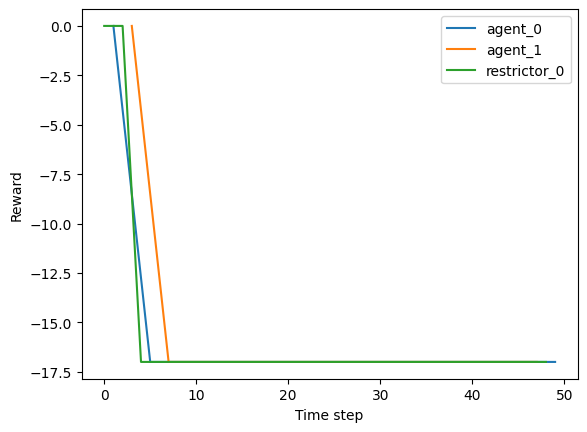

In [94]:
trajectory.groupby('agent')['reward'].plot(legend=True, xlabel='Time step', ylabel='Reward');

Text(0.5, 0, 'Time step')

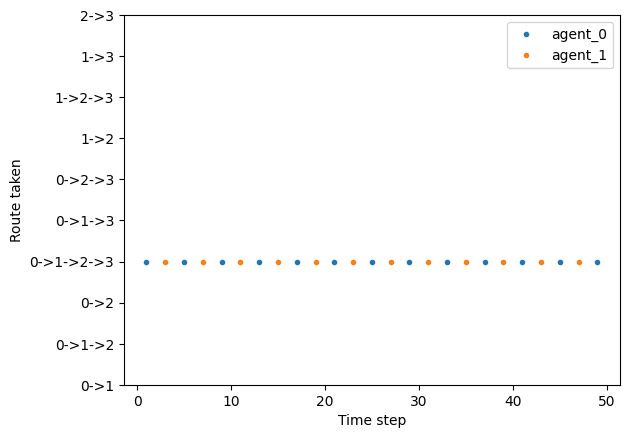

In [95]:
ax, *_ = trajectory[trajectory['agent'] != 'restrictor_0'].groupby('agent')['action'].plot(style='.', legend=True)
ax.set_yticks(list(route_indices.values()), [edge_path_to_node_path(route, edge_list) for route in route_indices.keys()]);
ax.set_ylabel('Route taken')
ax.set_xlabel('Time step')

## With self-learning restrictor

In [103]:
import gymnasium as gym

number_of_agents = 2

edge_list, edge_indices, edge_latencies, routes, route_list, route_indices = analyze_graph(graph)
number_of_edges = graph.number_of_edges()

agents = {f'agent_{i}': TrafficAgent(routes, route_indices, edge_indices) for i in range (number_of_agents)}
restrictor = TrafficRestrictor()

env = TrafficEnvironment(graph, list(agents), possible_routes, number_of_steps=100)

In [104]:


total_timesteps = 10
train_after_timesteps = 20


episode_num = 0
training_timesteps = 0
sample_from_restricted_space = False

ev_reward_all = []
ev_solved_all = []
ev_steps_all = []

while training_timesteps < total_timesteps:
    env.reset()
    episode_reward = 0
    episode_timesteps = 0
    episode_num += 1
    observation = None
    action = None
    last_td3_action = None

    for agent in env.agent_iter():
        next_observation, reward, termination, truncation, info = env.last()

        # Turn of the restrictor
        if agent == 'restrictor_0':
            episode_reward += reward
            episode_timesteps += 1

            if episode_timesteps > 1:
                replay_buffer.add(observation,
                                  last_td3_action,
                                  next,
                                  reward,
                                  termination or truncation)
            observation = next_observation

            training_timesteps += 1
            if training_timesteps < train_after_timesteps':
                if sample_from_restricted_space:
                    action = next_observation['restriction'].sample()
                else:
                    action = np.random.uniform(-110.0, 110.0, (1,))
            else:
                det_action = td3.select_action(observation)
                noise = np.random.normal(0, td3_config['max_action'] * td3_config['exploration_noise'], size=td3_config['action_dim'])
                action = (det_action + noise).clip(-td3_config['max_action'], td3_config['max_action'])

            if training_timesteps >= td3_config['train_after_timesteps']:
                td3.train(replay_buffer, td3_config['batch_size'])
            last_td3_action = action
        # Or restrictor
        else:
            action = agents[agent].act(next_observation)

        # None action if episode is done
        if termination or truncation:
            # print(f'{action} for {next_observation["restriction"]}, {restricted_environment.env.agent.x, restricted_environment.env.agent.y}')
            action = None

        env.step(action)

        if agent == 'restrictor_0' and training_timesteps % 500 == 0:
            print('Starting evaluation ...')
            ev_reward, ev_solved, ev_steps = evaluate(td3)
            ev_reward_all.append(ev_reward)
            ev_solved_all.append(ev_solved)
            ev_steps_all.append(ev_steps)

    print(f'Finished episode {episode_num} with reward {episode_reward} in {episode_timesteps} steps - goal reached: {termination}')

env.close()

KeyboardInterrupt: 